Train CNN on 'ImageNet' -> Remove classification layer -> make predictions on training set with CNN -> Output of this prediction is the extracted feature.

Extracted Features + Labels -> Train Gaussian Mixture Model (GMM) -> Predict on Test set of 'ImageNet' images 

Classes:
>69: Trilobite <br>
>70: Daddy Longleg <br>
>71: Scorpion <br>
>72: Black & Gold Spider <br>
>73: Barn Spider <br>
>74: Garden Spider <br>
>75: Black Widow <br>
>76: Tarantula <br>
>77: Wolf Spider <br>
>78: Tick <br>
>79: Centipede <br>

# Full 9

### Imports

In [2]:
# import libraries
from IPython.display import Image, display
import numpy as np
import os
from os.path import join
from PIL import ImageFile
import pandas as pd
from matplotlib import cm
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn import svm
from sklearn.mixture import GaussianMixture
from sklearn.isotonic import IsotonicRegression
import re
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import load_model
from tensorflow.keras import Model


ImageFile.LOAD_TRUNCATED_IMAGES = True
plt.style.use('fivethirtyeight')
%matplotlib inline

### Read & Format Training Data

In [3]:
def read_data(train_img_dir_n = "../OneClass/Ticks_2D/train", train_img_dir_s = "../OneClass/Other/Tick", natural_images_path = "../OneClass/Other/", size = 0):
    # import car images from natural images
    
    train_img_paths_n = [join(train_img_dir_n,filename) for filename in os.listdir(train_img_dir_n)]
    train_img_paths_s = [join(train_img_dir_s,filename) for filename in os.listdir(train_img_dir_s)]
    # import car images from stanford cars
    
    #all_train_img_paths_s = [join(train_img_dir_s,filename) for filename in os.listdir(train_img_dir_s)]

    # split cars data into train, test, and val
    #train_img_paths, test_img_paths_car = train_test_split(train_img_paths_n, test_size=0.25, random_state=42)
    train_img_paths, val_img_paths_car = train_test_split(train_img_paths_n, test_size=0.25, random_state=42)

    test_img_paths_car, _ = train_test_split(train_img_paths_s, test_size=1, random_state=42)
    print(len(test_img_paths_car))
    #  import ~car images
    
    test_img_paths_no_car = []
    count = 0
    for d in [d for d in os.listdir("../OneClass/Other") if d!= "Tick"]:
        if count > size:
            break
        test_img_dir_na = natural_images_path+d
        test_img_paths_no_car.append([join(test_img_dir_na,filename) for filename in os.listdir(test_img_dir_na)])
        count += 1
        
    test_img_paths_no_car_flat = [item for sublist in test_img_paths_no_car for item in sublist]
    test_img_paths_no_car, val_img_paths_no_car = train_test_split(test_img_paths_no_car_flat, test_size = 0.25, random_state = 42)

    return test_img_paths_car, test_img_paths_no_car, val_img_paths_car, val_img_paths_no_car, train_img_paths

def natural_img_dir(image_path):
    path_regex = r"Other\/(\w*)"
    if 'Other' in image_path:
        return re.findall(path_regex,image_path,re.MULTILINE)[0].strip()
    else:
        return 'Tick'

In [4]:
def paths(test_img_paths_car, test_img_paths_no_car):
    # create test dataframe
    all_test_paths = test_img_paths_car+test_img_paths_no_car
    test_path_df = pd.DataFrame({
        'path': all_test_paths,
        'is_car': [1 if path in test_img_paths_car else 0 for path in all_test_paths]
    })
    test_path_df = shuffle(test_path_df,random_state = 0).reset_index(drop = True)
    test_path_df['image_type'] = test_path_df['path'].apply(lambda x: natural_img_dir(x))
    all_test_paths = test_path_df['path'].tolist()

    #print('Distribution of Image Types in Test Set')
    #print(test_path_df['image_type'].value_counts())
    return all_test_paths, test_path_df

In [5]:
def val_paths(val_img_paths_car, val_img_paths_no_car):
    # create val dataframe
    all_val_paths = val_img_paths_car+val_img_paths_no_car
    val_path_df = pd.DataFrame({
        'path': all_val_paths,
        'is_car': [1 if path in val_img_paths_car else 0 for path in all_val_paths]
    })
    val_path_df = shuffle(val_path_df,random_state = 0).reset_index(drop = True)
    val_path_df['image_type'] = val_path_df['path'].apply(lambda x: natural_img_dir(x))
    all_val_paths = val_path_df['path'].tolist()

    #print('Distribution of Image Types in Validation Set')
    #print(val_path_df['image_type'].value_counts())
    return all_val_paths, val_path_df

### Feature Extraction With ResNet50
Removing the prediction layer of the pretrained Resnet50 model allows features to quickly be extracted from selected images.

In [6]:
def read_and_prep_images(img_paths, img_height, img_width):
    imgs = [load_img(img_path, target_size=(img_height, img_width)) for img_path in img_paths]
    img_array = np.array([img_to_array(img) for img in imgs])
    #output = img_array
    output = preprocess_input(img_array)
    return(output)

def path_to_set(imgSize, train_img_paths, all_test_paths, all_val_paths):
    # prepare images for resnet50
    image_size = imgSize

    X_train = read_and_prep_images(train_img_paths, image_size, image_size)
    X_test = read_and_prep_images(all_test_paths, image_size, image_size)
    X_val = read_and_prep_images(all_val_paths, image_size, image_size)

    return X_train, X_test, X_val

In [7]:
def feature_extraction(X_train, X_test, X_val, image_size):
    # get features from resnet50 

    #resnet_weights_path = '../OneClass/Models/augmented_resnet50-saved-model-14-val_acc-0.28.hdf5'
    resnet_weights_path = 'imagenet'
    # X : images numpy array
    resnet_model = ResNet50(input_shape=(image_size, image_size, 3), weights=resnet_weights_path, include_top=False, pooling='avg')  # Since top layer is the fc layer used for predictions


    X_train = resnet_model.predict(X_train)
    X_test = resnet_model.predict(X_test)
    X_val = resnet_model.predict(X_val)

    return X_train, X_test, X_val

### Apply PCA scaling
Principal Component Analysis

In [8]:
def scaling(X_train, X_test, X_val):

    # Apply standard scaler to output from resnet50
    ss = StandardScaler()
    ss.fit(X_train)
    X_train = ss.transform(X_train)
    X_test = ss.transform(X_test)
    X_val = ss.transform(X_val)

    # Take PCA to reduce feature space dimensionality
    pca = PCA(n_components=256, whiten=True)
    pca = pca.fit(X_train)
    print('Explained variance percentage = %0.2f' % sum(pca.explained_variance_ratio_))
    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)
    X_val = pca.transform(X_val)

    return X_train, X_test, X_val

### Gaussian Mixture Model

In [65]:
def train_Model(val_path_df, X_train, X_test, X_val, test_path_df, all_test_paths, cov, n):
  y_val = val_path_df['is_car'].tolist()

  gmm_clf = GaussianMixture(covariance_type=cov, n_components=n, max_iter=int(1e7))  # From Article (These params should be optimized for this problem)
  gmm_clf.fit(X_train)
  log_probs_val = gmm_clf.score_samples(X_val)
  isotonic_regressor = IsotonicRegression(out_of_bounds='clip')
  isotonic_regressor.fit(log_probs_val, y_val)  # y_val is for labels 0 - not car 1 - car (validation set)

  # Obtaining results on the test set
  log_probs_test = gmm_clf.score_samples(X_test)
  test_probabilities = isotonic_regressor.predict(log_probs_test)
  test_predictions = [1 if prob >= 0.004 else 0 for prob in test_probabilities]

  gmm_results = pd.DataFrame({
    'path': all_test_paths,
    'gmm_preds': test_predictions
  })

  gmm_results = gmm_results.merge(test_path_df)
  gmm_results.head()

  return gmm_clf, test_probabilities, test_predictions, gmm_results



In [78]:
def confusion(gmm_results, test_predictions):
    print('roc auc score: gmm_preds')
    gmm_preds = gmm_results['gmm_preds']
    actual = gmm_results['is_car']
    print(roc_auc_score(actual, gmm_preds))
    print(classification_report(actual, gmm_preds))
    sns.heatmap(confusion_matrix(actual, gmm_preds),annot = True,fmt = '2.0f')
    plt.show()
    new = [(0 if i else 1) for i in test_predictions]

    return gmm_preds, actual

In [11]:
def plot_gmm(predictions, gmm_preds, actual, X_test):
    new = [(0 if i else 1) for i in predictions]
    for i in range(len(gmm_preds)):
        var = gmm_preds[i] - actual[i]
        if var == 1: # false _pos
            new[i] = 0

        elif var == 0 and gmm_preds[i] == 1: # true_pos
            new[i] = 1



        elif var == 0 and gmm_preds[i] == 0: # true_neg
            new[i] = 2


        elif var == -1: # false_neg
            new[i] = 3
        
    plt.scatter(X_test[:, 0], X_test[:, 1], c=new, s=70, cmap='viridis', alpha=0.1);
    
    return

### Run 2D-Ticks

2699
125/125 [==============================] - 40s 322ms/step
Explained variance percentage = 0.94


c:\Users\ShepDaddy\anaconda3\envs\ECE371H\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


roc auc score: gmm_preds
0.6208321220585022
              precision    recall  f1-score   support

           0       0.83      0.98      0.90      9750
           1       0.78      0.26      0.39      2699

    accuracy                           0.82     12449
   macro avg       0.80      0.62      0.64     12449
weighted avg       0.82      0.82      0.79     12449



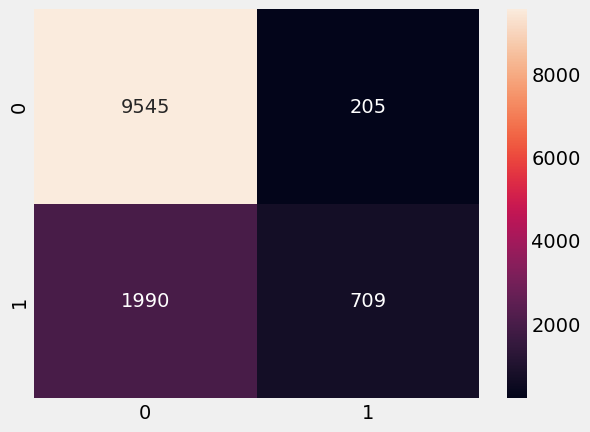

In [110]:
train_img_dir_n = "../OneClass/Ticks_2D/train" # train directory
train_img_dir_s = "../OneClass/Ticks_INaturalist/train"
natural_images_path = "../OneClass/Other/"

test_img_paths_car, test_img_paths_no_car, val_img_paths_car, val_img_paths_no_car, train_img_paths  = read_data(train_img_dir_n, train_img_dir_s, natural_images_path, 1000)

all_test_paths, test_path_df = paths(test_img_paths_car, test_img_paths_no_car)
all_val_paths, val_path_df = val_paths(val_img_paths_car, val_img_paths_no_car)

X_train, X_test, X_val = path_to_set(150, train_img_paths, all_test_paths, all_val_paths)
X_train, X_test, X_val = feature_extraction(X_train, X_test, X_val, 150)
X_train, X_test, X_val = scaling(X_train, X_test, X_val)

gmm_clf, test_probabilities, test_predictions, gmm_results = train_Model(val_path_df, X_train, X_test, X_val, test_path_df, all_test_paths, 'full', 2)
gmm_preds, actual = confusion(gmm_results, test_predictions)

0.003


c:\Users\ShepDaddy\anaconda3\envs\ECE371H\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


test Mean: 0.03243745575754468
0.0
X Mean: 0.11961484389501886 
X Median:  0.0 
X Max/Min:  1.0 / 0.0
Y Mean: 0.008304966466976359 
Y Median:  0.0 
Y Max/Min:  1.0 / 0.0
roc auc score: gmm_preds
0.6462398989179277
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      9750
           1       0.66      0.34      0.45      2699

    accuracy                           0.82     12449
   macro avg       0.75      0.65      0.67     12449
weighted avg       0.80      0.82      0.80     12449



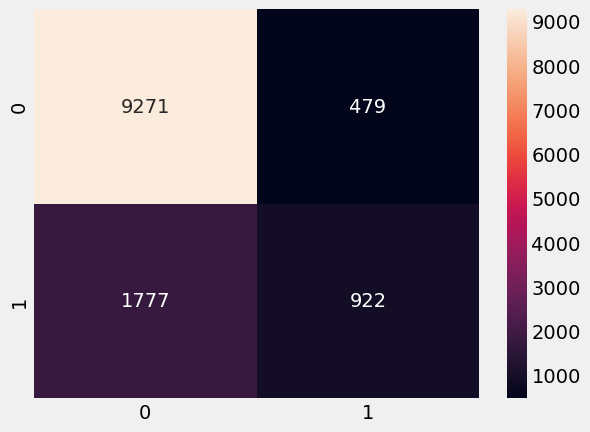

In [111]:
import statistics
#def train_Model(val_path_df, X_train, X_test, X_val, test_path_df, all_test_paths, cov, n):
i=30
print(i*1e-4)
y_val = val_path_df['is_car'].tolist()

gmm_clf = GaussianMixture(covariance_type='full', n_components=2, max_iter=int(1e12))  # From Article (These params should be optimized for this problem)
gmm_clf.fit(X_train)
log_probs_val = gmm_clf.score_samples(X_val)
isotonic_regressor = IsotonicRegression(out_of_bounds='clip')
isotonic_regressor.fit(log_probs_val, y_val)  # y_val is for labels 0 - not car 1 - car (validation set)

  # Obtaining results on the test set
log_probs_test = gmm_clf.score_samples(X_test)
test_probabilities = isotonic_regressor.predict(log_probs_test)
test_predictions = [1 if prob >= i*1e-4 else 0 for prob in test_probabilities]

gmm_results = pd.DataFrame({
  'path': all_test_paths,
  'gmm_preds': test_predictions
  })

gmm_results = gmm_results.merge(test_path_df)
gmm_results.head()


print('test Mean:', sum(test_probabilities)/len(test_probabilities))
print(statistics.mode(test_probabilities))
x=[]
y =[]
for i in range(len(test_probabilities)):
    if gmm_results['is_car'][i]:
          x.append(test_probabilities[i])
    else:
        y.append(test_probabilities[i])
    #print(i, gmm_results['is_car'][i], test_probabilities[i])
#print('\n\nX:\n\n')
#[print(i) for i in x]
    

print('X Mean:', statistics.mean(x), '\nX Median: ', statistics.median(x), '\nX Max/Min: ', max(x), '/', min(x))
print('Y Mean:', statistics.mean(y), '\nY Median: ', statistics.median(y), '\nY Max/Min: ', max(y), '/', min(y))

gmm_preds, actual = confusion(gmm_results, test_predictions)



In [62]:
import statistics
print('test Mean:', sum(test_probabilities)/len(test_probabilities))
print(statistics.mode(test_probabilities))
x=[]
y =[]
for i in range(len(test_probabilities)):
    if gmm_results['is_car'][i]:
        x.append(test_probabilities[i])
    else:
        y.append(test_probabilities[i])
    #print(i, gmm_results['is_car'][i], test_probabilities[i])
#print('\n\nX:\n\n')
#[print(i) for i in x]
    

print('X Mean:', statistics.mean(x), '\nX Median: ', statistics.median(x), '\nX Max/Min: ', max(x), '/', min(x))
print('Y Mean:', statistics.mean(y), '\nY Median: ', statistics.median(y), '\nY Max/Min: ', max(y), '/', min(y))


test Mean: 0.045753668310930404
0.01697045883092395


X:


X Mean: 0.1320866966803198 
X Median:  0.01697045883092395 
X Max/Min:  1.0 / 0.0
Y Mean: 0.021854915124367835 
Y Median:  0.01697045883092395 
Y Max/Min:  1.0 / 0.0


roc auc score: gmm_preds
0.57976348670575
              precision    recall  f1-score   support

           0       0.96      0.24      0.39      9750
           1       0.14      0.92      0.24      1299

    accuracy                           0.32     11049
   macro avg       0.55      0.58      0.31     11049
weighted avg       0.86      0.32      0.37     11049



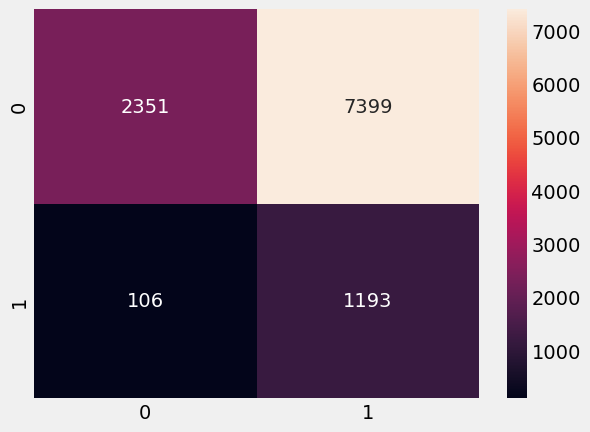

In [ ]:
gmm_preds, actual = confusion(gmm_results, test_predictions)

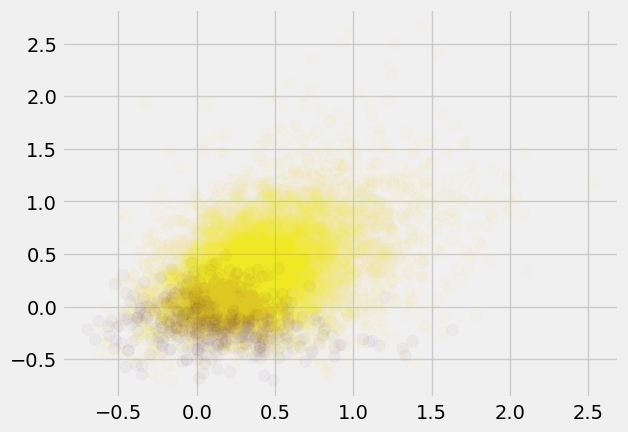

In [15]:
new = [(0 if i else 1) for i in test_predictions]

    
plt.scatter(X_test[:, 0], X_test[:, 1], c=new, s=70, cmap='viridis', alpha=0.03);

125/125 [==============================] - 81s 649ms/step
Explained variance percentage = 0.94


c:\Users\ShepDaddy\anaconda3\envs\ECE371H\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


roc auc score: gmm_preds
0.6420418768584757
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      9750
           1       0.65      0.33      0.44      2699

    accuracy                           0.82     12449
   macro avg       0.74      0.64      0.67     12449
weighted avg       0.80      0.82      0.79     12449



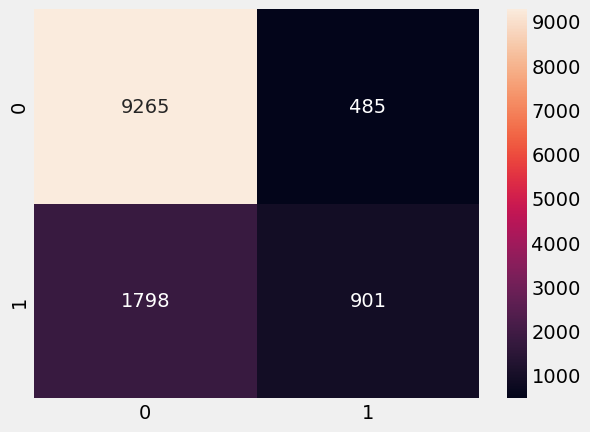

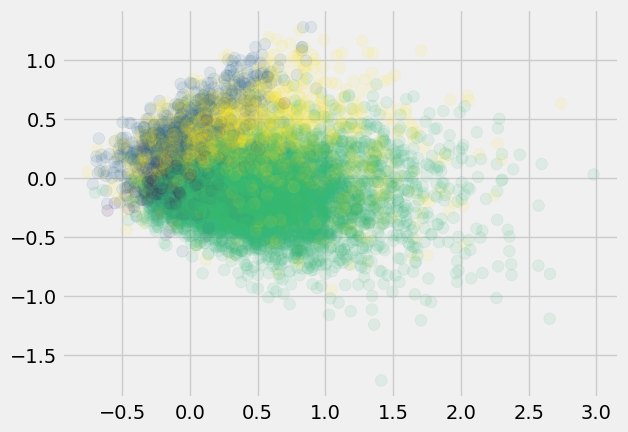

In [63]:
X_train, X_test, X_val = path_to_set(224, train_img_paths, all_test_paths, all_val_paths)
X_train, X_test, X_val = feature_extraction(X_train, X_test, X_val, 224)
X_train, X_test, X_val = scaling(X_train, X_test, X_val)

gmm_clf, test_probabilities, test_predictions, gmm_results = train_Model(val_path_df, X_train, X_test, X_val, test_path_df, all_test_paths, 'full', 2)
gmm_preds, actual = confusion(gmm_results, test_predictions)

plot_gmm(test_predictions, gmm_preds, actual, X_test)

In [64]:
import statistics
print('test Mean:', sum(test_probabilities)/len(test_probabilities))
print(statistics.mode(test_probabilities))
x=[]
y =[]
for i in range(len(test_probabilities)):
    if gmm_results['is_car'][i]:
        x.append(test_probabilities[i])
    else:
        y.append(test_probabilities[i])
    #print(i, gmm_results['is_car'][i], test_probabilities[i])
print('\n\nX:\n\n')
#[print(i) for i in x]
    

print('X Mean:', statistics.mean(x), '\nX Median: ', statistics.median(x), '\nX Max/Min: ', max(x), '/', min(x))
print('Y Mean:', statistics.mean(y), '\nY Median: ', statistics.median(y), '\nY Max/Min: ', max(y), '/', min(y))


test Mean: 0.026522917752807237
0.0


X:


X Mean: 0.10679837700490363 
X Median:  0.0 
X Max/Min:  1.0 / 0.0
Y Mean: 0.0043010239557401565 
Y Median:  0.0 
Y Max/Min:  1.0 / 0.0


In [45]:
roc_auc = []
for i in range(1,30):
    gmm_clf, test_probabilities, test_predictions, gmm_results = train_Model(val_path_df, X_train, X_test, X_val, test_path_df, all_test_paths, 'full', i)
    L = roc_auc_score(gmm_results['is_car'], gmm_results['gmm_preds'])
    roc_auc.append(L)
    print(i, '|', L)

c:\Users\ShepDaddy\anaconda3\envs\ECE371H\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
c:\Users\ShepDaddy\anaconda3\envs\ECE371H\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


1 | 0.6457091610378013
2 | 0.6801105442661575


c:\Users\ShepDaddy\anaconda3\envs\ECE371H\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


3 | 0.6424656235452827


c:\Users\ShepDaddy\anaconda3\envs\ECE371H\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


4 | 0.6411938704743447


c:\Users\ShepDaddy\anaconda3\envs\ECE371H\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


5 | 0.6715385185396301


c:\Users\ShepDaddy\anaconda3\envs\ECE371H\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


6 | 0.6896197452047768


c:\Users\ShepDaddy\anaconda3\envs\ECE371H\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


7 | 0.6825091534376454


c:\Users\ShepDaddy\anaconda3\envs\ECE371H\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


8 | 0.6088459733424536


c:\Users\ShepDaddy\anaconda3\envs\ECE371H\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


9 | 0.6114351944214856


c:\Users\ShepDaddy\anaconda3\envs\ECE371H\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


10 | 0.6694259412317952


c:\Users\ShepDaddy\anaconda3\envs\ECE371H\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


11 | 0.6912976506018373


c:\Users\ShepDaddy\anaconda3\envs\ECE371H\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


12 | 0.6497249123607034


c:\Users\ShepDaddy\anaconda3\envs\ECE371H\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


13 | 0.5049218418977589


c:\Users\ShepDaddy\anaconda3\envs\ECE371H\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


14 | 0.6864067033374184


c:\Users\ShepDaddy\anaconda3\envs\ECE371H\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


15 | 0.625533540437579


c:\Users\ShepDaddy\anaconda3\envs\ECE371H\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


16 | 0.5035634850514435


c:\Users\ShepDaddy\anaconda3\envs\ECE371H\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


17 | 0.6245633045477432


c:\Users\ShepDaddy\anaconda3\envs\ECE371H\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


18 | 0.506711564587074


c:\Users\ShepDaddy\anaconda3\envs\ECE371H\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


19 | 0.6660512250501135


c:\Users\ShepDaddy\anaconda3\envs\ECE371H\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


20 | 0.5071814442196065


c:\Users\ShepDaddy\anaconda3\envs\ECE371H\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


21 | 0.5279304965751798


c:\Users\ShepDaddy\anaconda3\envs\ECE371H\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


22 | 0.6274689201128623


c:\Users\ShepDaddy\anaconda3\envs\ECE371H\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


23 | 0.6544634195000998


c:\Users\ShepDaddy\anaconda3\envs\ECE371H\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


24 | 0.6219862247176067


c:\Users\ShepDaddy\anaconda3\envs\ECE371H\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


25 | 0.5056429826811449


c:\Users\ShepDaddy\anaconda3\envs\ECE371H\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


26 | 0.5104885190146399


c:\Users\ShepDaddy\anaconda3\envs\ECE371H\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


27 | 0.6008382401839238


c:\Users\ShepDaddy\anaconda3\envs\ECE371H\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


28 | 0.6006503073313003


c:\Users\ShepDaddy\anaconda3\envs\ECE371H\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


29 | 0.5065974672480785


In [46]:
print(max(roc_auc))

0.6912976506018373


c:\Users\ShepDaddy\anaconda3\envs\ECE371H\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


roc auc score: gmm_preds
0.5022058502199295
              precision    recall  f1-score   support

           0       0.83      0.02      0.03      9750
           1       0.22      0.99      0.36      2699

    accuracy                           0.23     12449
   macro avg       0.53      0.50      0.19     12449
weighted avg       0.70      0.23      0.10     12449



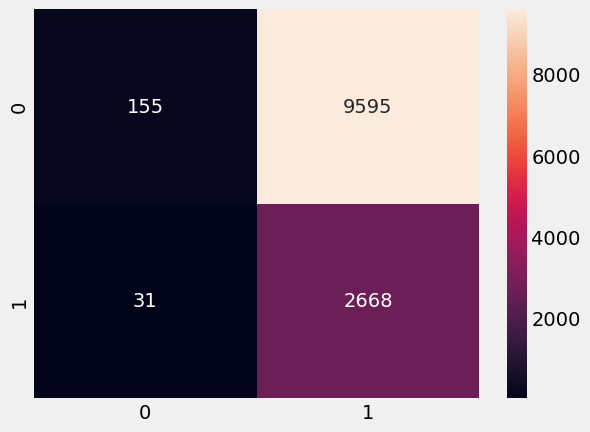

In [60]:
gmm_clf, test_probabilities, test_predictions, gmm_results = train_Model(val_path_df, X_train, X_test, X_val, test_path_df, all_test_paths, 'full', 2)
    
gmm_preds, actual = confusion(gmm_results, test_predictions)

C:\Users\ShepDaddy\AppData\Local\Temp\ipykernel_16916\3943257299.py:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(gmm_clf.means_[:, 0], gmm_clf.means_[:, 1],  s=70, cmap='viridis', alpha=0.1);


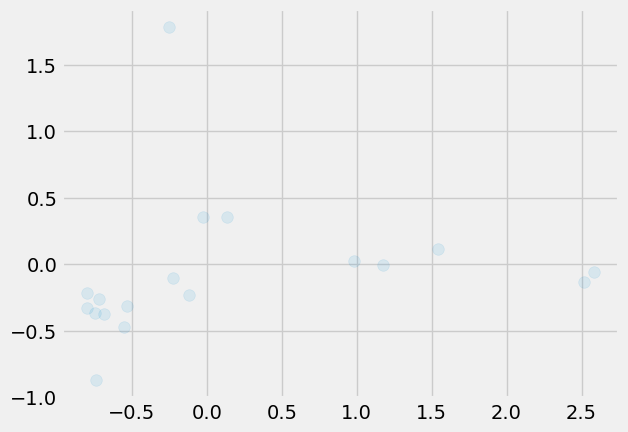

In [17]:
plt.scatter(gmm_clf.means_[:, 0], gmm_clf.means_[:, 1],  s=70, cmap='viridis', alpha=0.1);

### Run 3D Ticks

In [ ]:
def train_Model(val_path_df, X_train, X_test, X_val, test_path_df, all_test_paths):
  y_val = val_path_df['is_car'].tolist()

  gmm_clf = GaussianMixture(covariance_type='spherical', n_components=18, max_iter=int(1e7))  # From Article (These params should be optimized for this problem)
  gmm_clf.fit(X_train)
  log_probs_val = gmm_clf.score_samples(X_val)
  isotonic_regressor = IsotonicRegression(out_of_bounds='clip')
  isotonic_regressor.fit(log_probs_val, y_val)  # y_val is for labels 0 - not car 1 - car (validation set)

  # Obtaining results on the test set
  log_probs_test = gmm_clf.score_samples(X_test)
  test_probabilities = isotonic_regressor.predict(log_probs_test)
  test_predictions = [1 if prob >= 0.0015 else 0 for prob in test_probabilities]

  gmm_results = pd.DataFrame({
    'path': all_test_paths,
    'gmm_preds': test_predictions
  })

  gmm_results = gmm_results.merge(test_path_df)
  gmm_results.head()

  return gmm_clf, test_probabilities, test_predictions, gmm_results

2699
106/106 [==============================] - 34s 322ms/step
Explained variance percentage = 0.99


c:\Users\ShepDaddy\anaconda3\envs\ECE371H\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


roc auc score: gmm_preds
0.5275758353046237
              precision    recall  f1-score   support

           0       0.79      0.99      0.88      9750
           1       0.68      0.06      0.12      2699

    accuracy                           0.79     12449
   macro avg       0.74      0.53      0.50     12449
weighted avg       0.77      0.79      0.72     12449



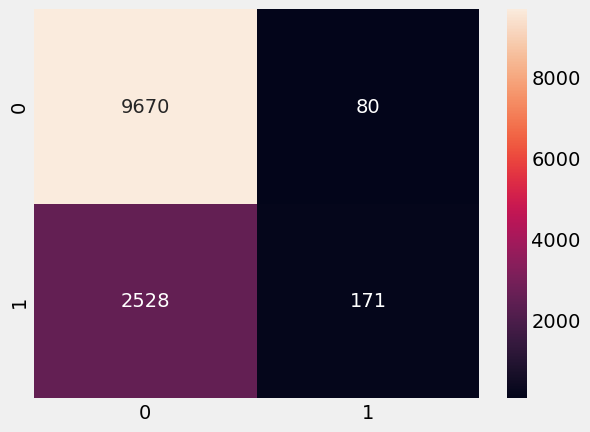

In [56]:
train_img_dir_n = "../OneClass/Ticks_3D/train"
train_img_dir_s = "../OneClass/Ticks_INaturalist/train"
natural_images_path = "../OneClass/Other/"

test_img_paths_car, test_img_paths_no_car, val_img_paths_car, val_img_paths_no_car, train_img_paths  = read_data(train_img_dir_n, train_img_dir_s, natural_images_path, 1000)

all_test_paths, test_path_df = paths(test_img_paths_car, test_img_paths_no_car)
all_val_paths, val_path_df = val_paths(val_img_paths_car, val_img_paths_no_car)

X_train, X_test, X_val = path_to_set(150, train_img_paths, all_test_paths, all_val_paths)
X_train, X_test, X_val = feature_extraction(X_train, X_test, X_val, 150)
X_train, X_test, X_val = scaling(X_train, X_test, X_val)

gmm_clf, test_probabilities, test_predictions, gmm_results = train_Model(val_path_df, X_train, X_test, X_val, test_path_df, all_test_paths, 'full', 2)
gmm_preds, actual = confusion(gmm_results, test_predictions)

In [ ]:
#gmm_preds, actual = confusion(gmm_results, test_predictions)

In [ ]:
plot_gmm(test_predictions, gmm_preds, actual)

106/106 [==============================] - 72s 674ms/step
Explained variance percentage = 0.99


c:\Users\ShepDaddy\anaconda3\envs\ECE371H\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


roc auc score: gmm_preds
0.520472140678884
              precision    recall  f1-score   support

           0       0.79      1.00      0.88      9750
           1       0.93      0.04      0.08      2699

    accuracy                           0.79     12449
   macro avg       0.86      0.52      0.48     12449
weighted avg       0.82      0.79      0.71     12449



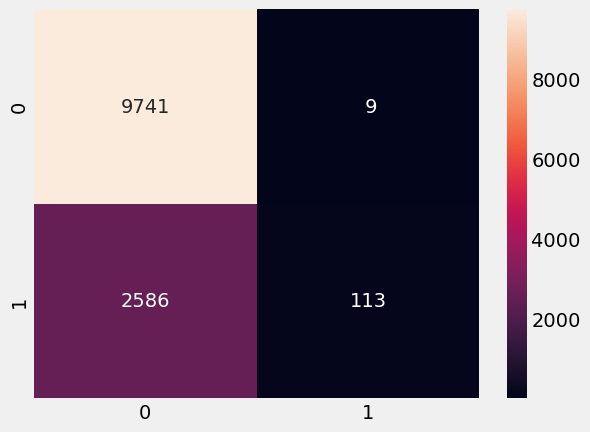

TypeError: plot_gmm() missing 1 required positional argument: 'X_test'

In [57]:
X_train, X_test, X_val = path_to_set(224, train_img_paths, all_test_paths, all_val_paths)
X_train, X_test, X_val = feature_extraction(X_train, X_test, X_val, 224)
X_train, X_test, X_val = scaling(X_train, X_test, X_val)

gmm_clf, test_probabilities, test_predictions, gmm_results = train_Model(val_path_df, X_train, X_test, X_val, test_path_df, all_test_paths, 'full', 2)
gmm_preds, actual = confusion(gmm_results, test_predictions)

plot_gmm(test_predictions, gmm_preds, actual, X_test)

### Run ImageNet Ticks

2699
112/112 [==============================] - 38s 335ms/step
Explained variance percentage = 0.85


c:\Users\ShepDaddy\anaconda3\envs\ECE371H\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


roc auc score: gmm_preds
0.5035430976335015
              precision    recall  f1-score   support

           0       0.83      0.03      0.05      9750
           1       0.22      0.98      0.36      2699

    accuracy                           0.23     12449
   macro avg       0.52      0.50      0.21     12449
weighted avg       0.70      0.23      0.12     12449



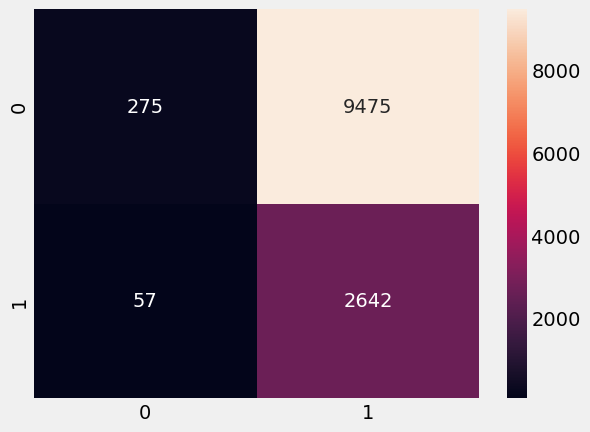

In [58]:
train_img_dir_n = "../OneClass/Other/Tick"
train_img_dir_s = "../OneClass/Ticks_INaturalist/train"
natural_images_path = "../OneClass/Other/"

test_img_paths_car, test_img_paths_no_car, val_img_paths_car, val_img_paths_no_car, train_img_paths  = read_data(train_img_dir_n, train_img_dir_s, natural_images_path, 1000)

all_test_paths, test_path_df = paths(test_img_paths_car, test_img_paths_no_car)
all_val_paths, val_path_df = val_paths(val_img_paths_car, val_img_paths_no_car)

X_train, X_test, X_val = path_to_set(150, train_img_paths, all_test_paths, all_val_paths)
X_train, X_test, X_val = feature_extraction(X_train, X_test, X_val, 150)
X_train, X_test, X_val = scaling(X_train, X_test, X_val)

gmm_clf, test_probabilities, test_predictions, gmm_results = train_Model(val_path_df, X_train, X_test, X_val, test_path_df, all_test_paths, 'full', 2)
gmm_preds, actual = confusion(gmm_results, test_predictions)

In [ ]:
gmm_preds, actual = confusion(gmm_results, test_predictions)

In [ ]:
plot_gmm(test_predictions, gmm_preds, actual)

112/112 [==============================] - 80s 717ms/step
Explained variance percentage = 0.85


c:\Users\ShepDaddy\anaconda3\envs\ECE371H\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


roc auc score: gmm_preds
0.5017641861658164
              precision    recall  f1-score   support

           0       0.82      0.02      0.03      9750
           1       0.22      0.99      0.36      2699

    accuracy                           0.23     12449
   macro avg       0.52      0.50      0.19     12449
weighted avg       0.69      0.23      0.10     12449



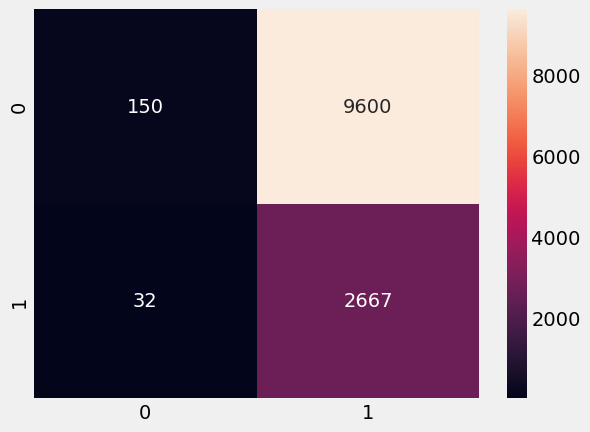

TypeError: plot_gmm() missing 1 required positional argument: 'X_test'

In [59]:
X_train, X_test, X_val = path_to_set(224, train_img_paths, all_test_paths, all_val_paths)
X_train, X_test, X_val = feature_extraction(X_train, X_test, X_val, 224)
X_train, X_test, X_val = scaling(X_train, X_test, X_val)

gmm_clf, test_probabilities, test_predictions, gmm_results = train_Model(val_path_df, X_train, X_test, X_val, test_path_df, all_test_paths, 'full', 2)
gmm_preds, actual = confusion(gmm_results, test_predictions)


plot_gmm(test_predictions, gmm_preds, actual)